<center>
<img align ="center" src="./assets/hacettepe2.png" alt="Hacettepe University Logo" width="200\">
<h1><b>Hacettepe University</b></h1>
<h1><b>ELE492 : Image Processing - Homework 4</b></h1>

<h1>Kaan ARI - 21628042</h1>

___

<br>

```
I pledge that I have not received or given any aid in this homework. 
All the work presented below is my own work.
                                                                              - Kaan Arı | 21628042                                                    
```

<img align ="right" src="assets/signature.png" alt="Hacettepe University Logo" width="250">

___

# YOLO v3 Object Detection on Printed Circuit Board

## Introduction


![Dataset](./assets/hw4/dataset3.png)

The raw dataset that is used for this example can be found on [here](https://www.trust-hub.org/#/data).

I labelled all PCBs in the dataset by using [Roboflow](https://public.roboflow.com). You can download labelled dataset from [here](https://app.roboflow.com/ds/fLgY6fBd6w?key=5sxEo1vdxm)

## Preprocessing

I downloaded all the PCB zip files to Google Drive. Then I extract all of them in Google Drive. After that, I merged all the image files in the different folders into images in the single folder. 

The code below provides stated steps above.
#### Connect Google Drive with Google Colab

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

#### Download Dataset Zip Files
Download the zip files from the zip sources from **dataset_source.txt** to YOLOv3-PCB/dataset/ folder in Google Drive.

In [ ]:
!mkdir /content/gdrive/MyDrive/YOLOv3-PCB
!mkdir /content/gdrive/MyDrive/YOLOv3-PCB/dataset

!wget -P /content/gdrive/MyDrive/YOLOv3-PCB/dataset -i ./assets/hw4/dataset_source.txt

#### Check downloads

In [ ]:
!ls /content/gdrive/MyDrive/YOLOv3-PCB/dataset

#### Extract Zip Files

In [ ]:
!unzip "/content/gdrive/MyDrive/YOLOv3-PCB/dataset/*.zip" -d "/content/gdrive/MyDrive/YOLOv3-PCB/dataset/"

In [ ]:
%cd /content/gdrive/MyDrive/YOLOv3-PCB/dataset/
%ls

#### Moving All Microscope Image to images Folder

In [ ]:
import os
from shutil import copyfile
import cv2
from PIL import Image, ImageOps

# ================================================= #
#  Create Directory Map (Find all the image paths)  #
# ================================================= #
dirName = "."
listOfFile = os.listdir(dirName)
allFiles = list()
# Iterate over all the entries
for entry in listOfFile:
    # Create full path
    fullPath = os.path.join(dirName, entry)
    
    if os.path.isdir(fullPath) and "./s" in fullPath:
        allFiles.append(fullPath)

DSLR_folders = []
annotation_list = []
image_list = []

for folder in allFiles:
    listOfFile = os.listdir(folder)
    if not len(listOfFile) or not "Microscope" in listOfFile:
        continue

    fullPath = os.path.join(folder, "Microscope")  
    annotPath = os.path.join(fullPath, "annotation")
    imagePath = os.path.join(fullPath, "img")

    DSLR_folders.append(fullPath)
    annotation_list.append(annotPath)
    image_list.append(imagePath)

final_img_list = []
for folder in image_list:
    listOfFile = os.listdir(folder)

    for side in listOfFile:
        path2 = os.path.join(folder, side)
        if side.upper() == '.DS_STORE':
            continue # Passs DS_STORE Folder

        listOfFileSide = os.listdir(path2)
        path3 = os.path.join(path2, "1x")
        listOfFileSide = os.listdir(path3)

        for i in listOfFileSide:
            if "1x" in i and "40" in i:
                path4 = os.path.join(path3, i)
                imageFolder = os.listdir(path4)

                for folderImg in imageFolder:
                    if "TileScan" in folderImg and not "." in folderImg:
                        path5 = os.path.join(path4, folderImg)
                        images = os.listdir(path5)
                        images = [os.path.join(path5, image) for image in images]
                        final_img_list.extend(images)
                        

# ================================================= #
#       Copy Found Images to one common folder      #
# ================================================= #
%cd /content/gdrive/MyDrive/YOLOv3-PCB/dataset/

for File in final_img_list:
    if '.DS_STORE' in File.upper():
        continue
        
    file_name = "./images/"+File.split("/")[-1].split(".")[0]+".png"
    im = cv2.imread(File)
    cv2.imwrite(file_name, im)


## Labelling
Before manual labeling, I tried to use labels in the dataset. To do that, I wrote some Python scripts to merge all annotation into single one. However, I cannot figured it out due to the annotation mismatch. I could not use generated annotation in training. Therefore, I found Roboflow to label, augment (rotation, scaling, saturation, etc) and annotate the dataset. **Another advantage of using Roboflow is I can use it any time and in any place.**. My dataset has 361 partial PCB board photos taken by microscope (There are different region images of the same PCB). With augmentation, I got 1000~ images in training set.

#### Labelling Examples
![Dataset](./assets/hw4/labelling.png)

### Issues and Approaches Related to Dataset and Labelling

First, I tried to find all components. I labelled all the presented components but it was not a good approach because the objects must be evenly distributed. Conversely, there was **1900~ instances for capacitor**, **1300~ instances for resistor**, **450~ for IC (Integrated Circuit)**, **100~ Inductor**, **50~ Transistor** in my dataset.

As it can be seen, it is wise to not use the objects that is under-presented. However, I tried to train our YOLO model by using all objects. Not suprisingly, I got poor results.

After that, I tried to use only Capacitors, Resistors and ICs. Even with these components, I did not get satisfactory results. I thought image resizing before put them into input layer reduced the details. Furthermore, SMD resistors and capacitors are too small. Since I have high resolution images, they almost seem to be same after resizing. Thus, prediction loss could not decrease. I think that if we have larger dataset, it may be possible to achieve good resuls.

Finally, I decided to use relatively bigger components. So, **I continued by choosing IC as only object in my YOLO model**. 

## Resizing

I must decrease image resolutions due to computational power. Original images are 1600x1200 and it is huge to uuse as an input layer. Therefore, I used resolution as **608x608** (it is stated to use multiple of 32 for efficieny). So after labelling, I scaled all the images and label coordinates to get proper input for our convolutional network.


## Data Augmentation

I increased our dataset by applying augmentation. I used **flip** (horizontal and vertical), **rotation** (between -3° and +3°), **saturation** (between -25% and +25%) and **exposure** (between -20% and +20%).

![Dataset](./assets/hw4/augmentation.jpg)

___

## Training

I used Keras YoLo v3 library to train my model.

In [ ]:
# Our YOLOv3 implementation calls for this Keras version
!pip install keras==2.2.4

# Verify our version is correct
!python -c 'import keras; print(keras.__version__)'

# Fetch Keras- YOLOv3
!git clone https://github.com/roboflow-ai/keras-yolo3
%ls

In [ ]:
# change directory to the repo we cloned
%cd keras-yolo3/
%ls

#### Download labelled and augmented dataset from Roboflow server

In [ ]:
# Paste Roboflow code from snippet here from above to here! eg !curl -L https://app.roboflow.ai/ds/eOSXbt7KWu?key=YOURKEY | jar -x
!curl -L https://app.roboflow.com/ds/fLgY6fBd6w?key=5sxEo1vdxm > roboflow.zip
!unzip roboflow.zip
!rm roboflow.zip
%cd train
%mv * ../
%cd ..

#### Setup Train Model

In [23]:
# download our DarkNet weights 
!wget https://pjreddie.com/media/files/yolov3.weights
    
# call a Python script to set up our architecture with downloaded pre-trained weights
!python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5

/bin/sh: wget: command not found
python: can't open file 'convert.py': [Errno 2] No such file or directory


#### Start Training
In training step, I first applied transfer learning with most of the hidden units are freezed. Later, I used all units are unfreezed model to fine tuning. After fine-tuning, model prediction 

In [27]:
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

def _main():
    annotation_path = '_annotations.txt'  # path to Roboflow data annotations
    log_dir = '../gdrive/MyDrive/logs/000/'                 # where we're storing our logs
    classes_path = '_classes.txt'         # path to Roboflow class names
    anchors_path = 'model_data/yolo_anchors.txt'
    class_names = get_classes(classes_path)
    print("-------------------CLASS NAMES-------------------")
    print(class_names)
    print("-------------------CLASS NAMES-------------------")
    num_classes = len(class_names)
    anchors = get_anchors(anchors_path)

    input_shape = (608,608) # multiple of 32, hw

    is_tiny_version = len(anchors)==6 # default setting
    if is_tiny_version:
        model = create_tiny_model(input_shape, anchors, num_classes,
            freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
    else:
        model = create_model(input_shape, anchors, num_classes,
            freeze_body=2, weights_path='../gdrive/MyDrive/logs/000/yolo.h5') # make sure you know what you freeze

    logging = TensorBoard(log_dir=log_dir)
    checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
        monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

    val_split = 0.2 # set the size of the validation set
    with open(annotation_path) as f:
        lines = f.readlines()
    np.random.seed(10101)
    np.random.shuffle(lines)
    np.random.seed(None)
    num_val = int(len(lines)*val_split)
    num_train = len(lines) - num_val

    # Train with frozen layers first, to get a stable loss.
    # Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
    if True:
        model.compile(optimizer=Adam(lr=1e-3), loss={
            # use custom yolo_loss Lambda layer.
            'yolo_loss': lambda y_true, y_pred: y_pred})

        batch_size = 32
        print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
        model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
                steps_per_epoch=max(1, num_train//batch_size),
                validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
                validation_steps=max(1, num_val//batch_size),
                epochs=500,
                initial_epoch=0,
                callbacks=[logging, checkpoint])
        model.save_weights(log_dir + 'trained_weights_stage_1.h5')

    # Unfreeze and continue training, to fine-tune.
    # Train longer if the result is not good.
    if True:
        for i in range(len(model.layers)):
            model.layers[i].trainable = True
        model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
        print('Unfreeze all of the layers.')

        batch_size = 32 # note that more GPU memory is required after unfreezing the body
        print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
        model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=100,
            initial_epoch=50,
            callbacks=[logging, checkpoint, reduce_lr, early_stopping])
        model.save_weights(log_dir + 'trained_weights_final.h5')

    # Further training if needed.


def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)


def create_model(input_shape, anchors, num_classes, load_pretrained=True, freeze_body=2,
            weights_path='model_data/yolo.h5'):
    '''create the training model'''
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16, 2:8}[l], w//{0:32, 1:16, 2:8}[l], \
        num_anchors//3, num_classes+5)) for l in range(3)]

    model_body = yolo_body(image_input, num_anchors//3, num_classes)
    print('Create YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2]:
            # Freeze darknet53 body or freeze all but 3 output layers.
            num = (185, len(model_body.layers)-3)[freeze_body-1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))

    model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
        arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.5})(
        [*model_body.output, *y_true])
    model = Model([model_body.input, *y_true], model_loss)

    return model

def create_tiny_model(input_shape, anchors, num_classes, load_pretrained=True, freeze_body=2,
            weights_path='model_data/tiny_yolo_weights.h5'):
    '''create the training model, for Tiny YOLOv3'''
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16}[l], w//{0:32, 1:16}[l], \
        num_anchors//2, num_classes+5)) for l in range(2)]

    model_body = tiny_yolo_body(image_input, num_anchors//2, num_classes)
    print('Create Tiny YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2]:
            # Freeze the darknet body or freeze all but 2 output layers.
            num = (20, len(model_body.layers)-2)[freeze_body-1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))

    model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
        arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.7})(
        [*model_body.output, *y_true])
    model = Model([model_body.input, *y_true], model_loss)

    return model

def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes):
    '''data generator for fit_generator'''
    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(annotation_lines)
            image, box = get_random_data(annotation_lines[i], input_shape, random=True)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
        yield [image_data, *y_true], np.zeros(batch_size)

def data_generator_wrapper(annotation_lines, batch_size, input_shape, anchors, num_classes):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes)

if __name__ == '__main__':
    _main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
-------------------CLASS NAMES-------------------
['IC']
-------------------CLASS NAMES-------------------
Create YOLOv3 model with 9 anchors and 1 classes.
Load weights ../drive/MyDrive/logs/000/yolo.h5.
Freeze the first 249 layers of total 252 layers.
Train on 778 samples, val on 194 samples, with batch size 32.
Epoch 1/500
24/24 [==============================] - 194s 8s/step - loss: 18.3570 - val_loss: 17.0724

Epoch 2/500
24/24 [==============================] - 157s 7s/step - loss: 15.7788 - val_loss: 16.4161
Epoch 3/500
24/24 [==============================] - 161s 7s/step - loss: 15.3730 - val_loss: 15.7771
Epoch 4/500
24/24 [==============================] - 113s 5s/step - loss: 15.0835 - val_loss: 15.4408
Epoch 5/500
24/24 [==============================] - 164s 7s/step - loss: 14.8580 - val_loss: 15.6975
Epoch 6/500
24/24 [=========================

## Results

I predicted the splitted test images in my computer instead of Google Colab. So that, below the command shows output result of input image.

In [ ]:
!python yolo_video.py --model="./logs/000/trained_weights_stage_1.h5" --classes="_classes.txt" --image

Here are some results of my model:

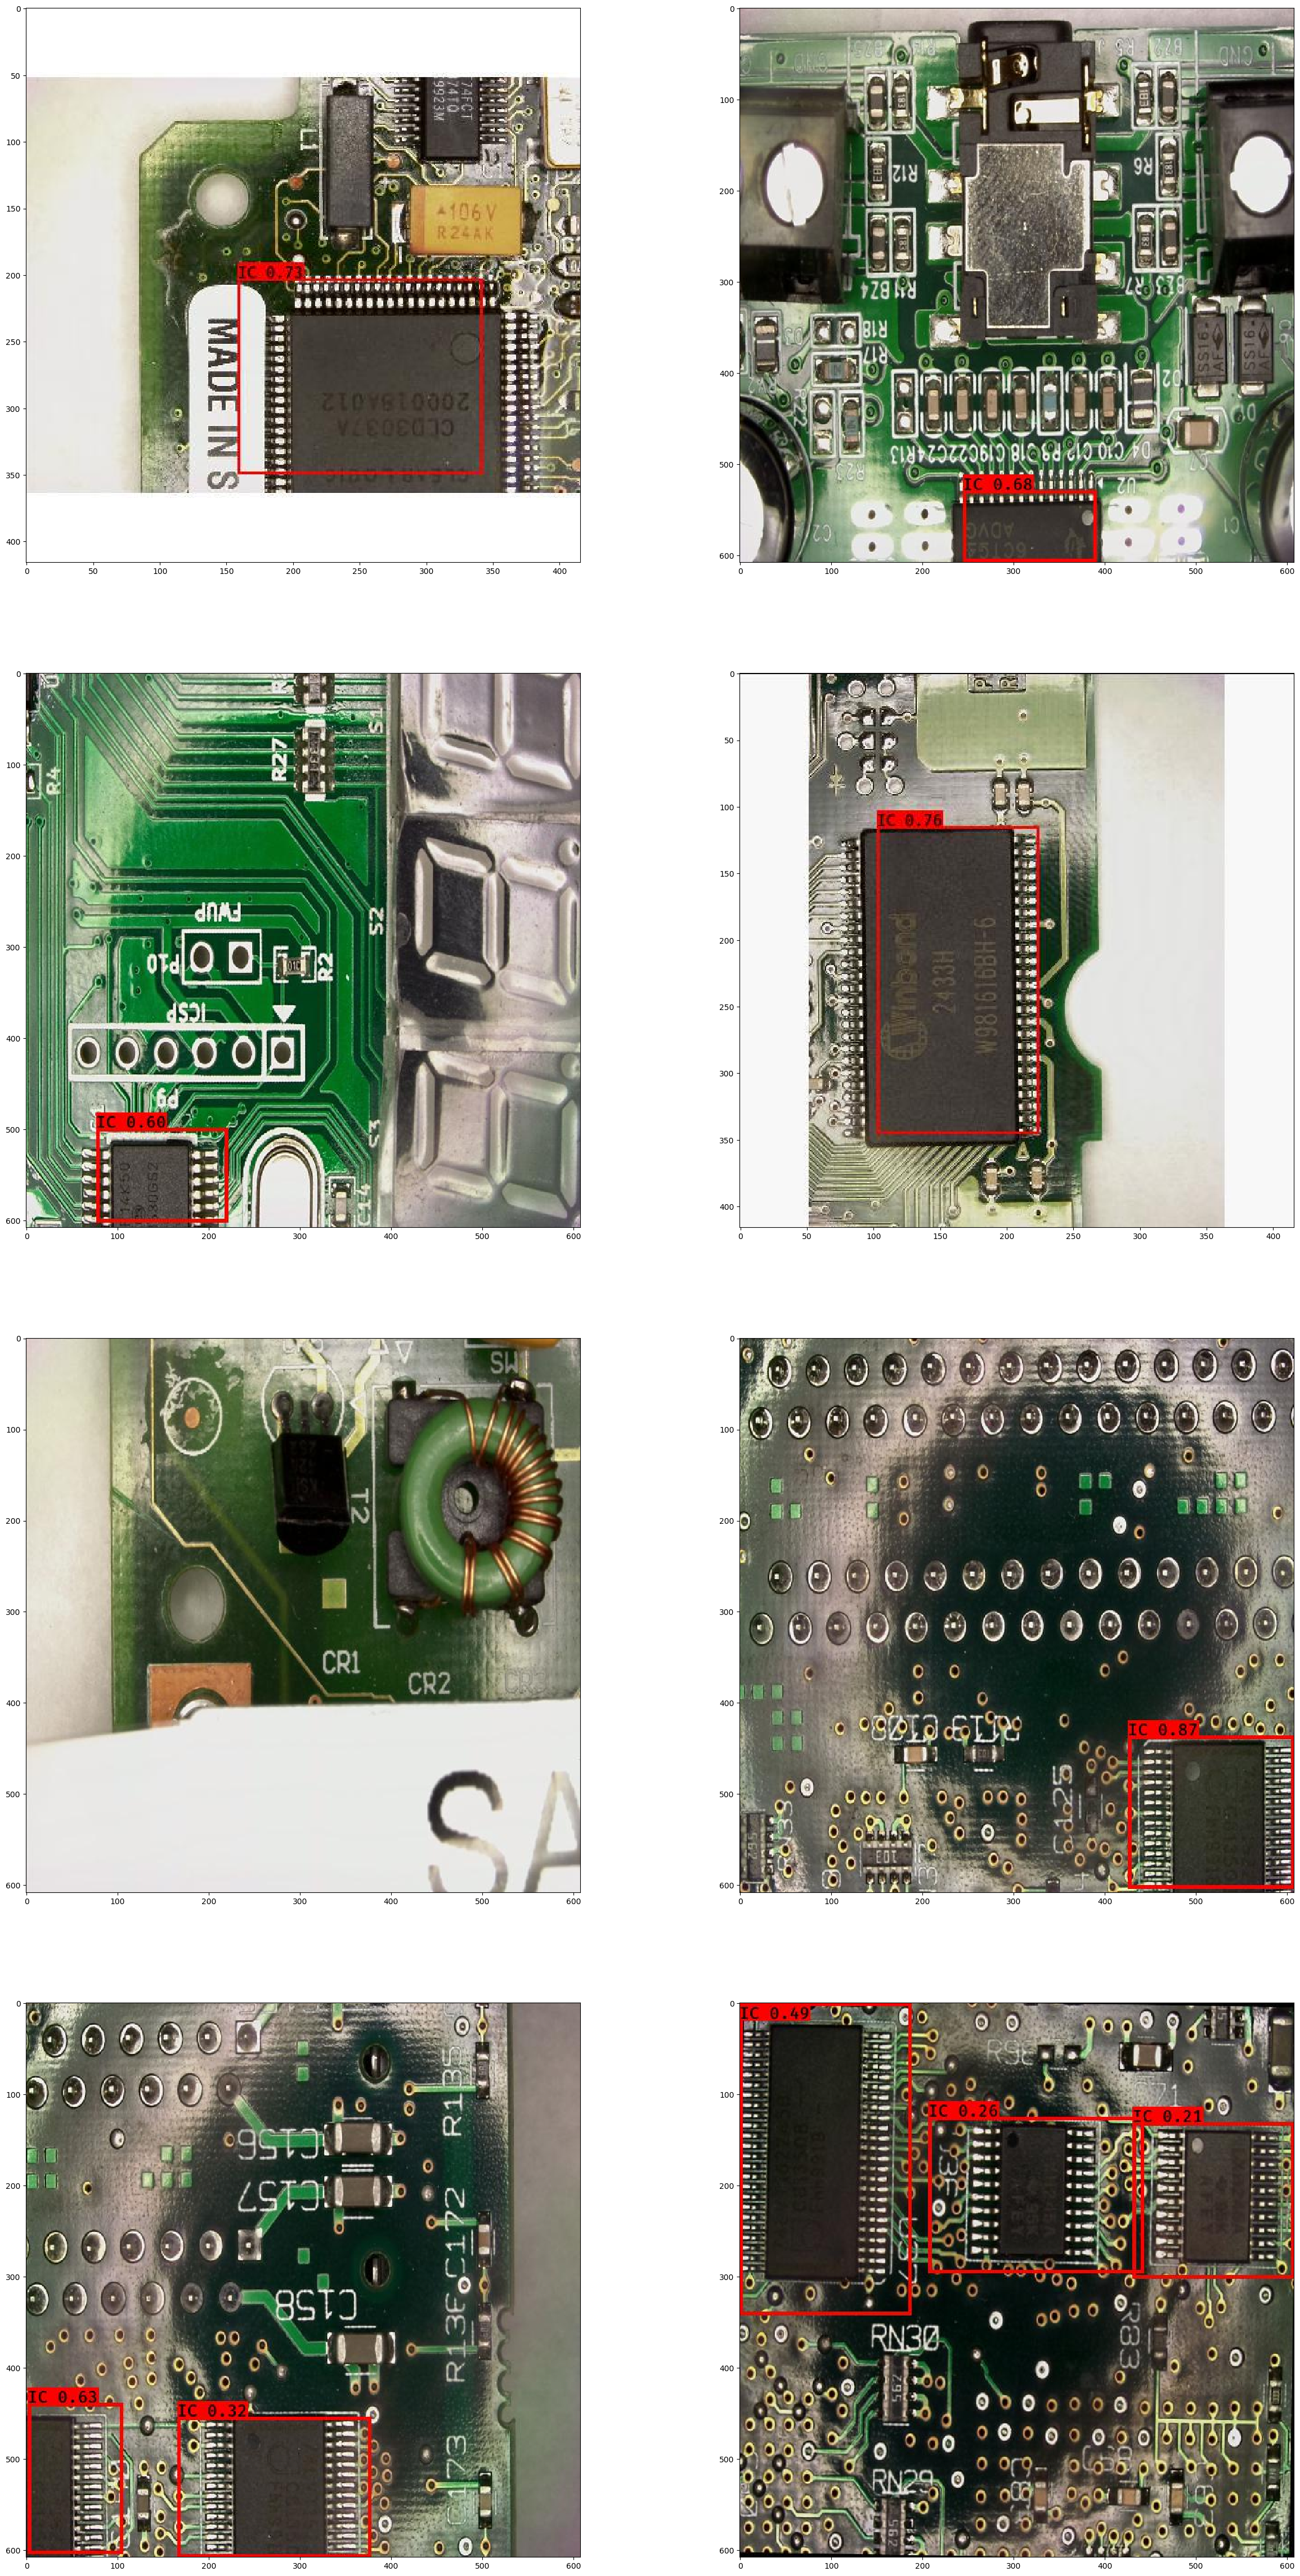

In [19]:
import matplotlib.pyplot as plt
import os, cv2

out_path = "./assets/hw4/out/"
image_list = os.listdir(out_path)

# Plotting Results
plt.figure(figsize=(30,60),dpi=100)

results = [cv2.cvtColor(cv2.imread(out_path+img), cv2.COLOR_BGR2RGB) for img in image_list]

for idx, img in enumerate(results):
    plt.subplot(4,2,idx+1)
    plt.imshow(img)

plt.show()

After all, it is not bad at all but needs some enhancements like more dataset. I think with more dataset, the component detection task is not overwhelming. Above the training epochs belong to fine-tuning steps. Before that model trained with 500 epochs. I tested the weights with loss is ~13 for the prediction.